# Improved LSTM baseline

This kernel is a somewhat improved version of [Keras - Bidirectional LSTM baseline](https://www.kaggle.com/CVxTz/keras-bidirectional-lstm-baseline-lb-0-051) along with some additional documentation of the steps. (NB: this notebook has been re-run on the new test set.)

In [1]:
import sys, os, re, csv, codecs, numpy as np, pandas as pd

from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.layers import Dense, Input, LSTM, Embedding, Dropout, Activation
from keras.layers.convolutional import Conv1D
from keras.models import Sequential
from keras.layers.normalization import BatchNormalization
from keras.layers import Bidirectional, GlobalMaxPool1D, MaxPooling1D, GlobalAveragePooling1D, Lambda
from keras.models import Model
from keras import initializers, regularizers, constraints, optimizers, layers
from keras import backend as K
import tensorflow as tf

import matplotlib.pyplot as plt
%matplotlib inline  

Using TensorFlow backend.


In [2]:
def normalize(s):
    """
    Given a text, cleans and normalizes it. Feel free to add your own stuff.
    """
    s = s.lower()
    # Replace ips
    s = re.sub(r'\d{1,3}\.\d{1,3}\.\d{1,3}\.\d{1,3}', ' _ip_ ', s)
    # Isolate punctuation
    s = re.sub(r'([\'\"\.\(\)\!\?\-\\\/\,])', r' \1 ', s)
    # Remove some special characters
    s = re.sub(r'([\;\:\|•«\n])', ' ', s)
    # Replace numbers and symbols with language
    s = s.replace('&', ' and ')
    s = s.replace('@', ' at ')
    s = s.replace('0', ' zero ')
    s = s.replace('1', ' one ')
    s = s.replace('2', ' two ')
    s = s.replace('3', ' three ')
    s = s.replace('4', ' four ')
    s = s.replace('5', ' five ')
    s = s.replace('6', ' six ')
    s = s.replace('7', ' seven ')
    s = s.replace('8', ' eight ')
    s = s.replace('9', ' nine ')
    return s


In [3]:
class ConvBlockLayer(object):
    """
    two layer ConvNet. Apply batch_norm and relu after each layer
    """

    def __init__(self, input_shape, num_filters):
        self.model = Sequential()
        # first conv layer
        self.model.add(Conv1D(filters=num_filters, kernel_size=3, strides=1, padding="same", input_shape=input_shape))
        self.model.add(BatchNormalization())
        self.model.add(Activation('relu'))

        # second conv layer
        self.model.add(Conv1D(filters=num_filters, kernel_size=3, strides=1, padding="same"))
        self.model.add(BatchNormalization())
        self.model.add(Activation('relu'))

    def __call__(self, inputs):
        return self.model(inputs)

We include the GloVe word vectors in our input files. To include these in your kernel, simple click 'input files' at the top of the notebook, and search 'glove' in the 'datasets' section.

In [4]:
path = 'data/'
EMBEDDING_FILE=f'wv/glove.6B.100d.txt'
TRAIN_DATA_FILE=f'{path}train.csv'
TEST_DATA_FILE=f'{path}test.csv'

Set some basic config parameters:

In [5]:
embed_size = 16 # char embed
maxlen = 1024 # max number of words in a comment to use

Read in our data and replace missing values:

In [6]:
train = pd.read_csv(TRAIN_DATA_FILE)
test = pd.read_csv(TEST_DATA_FILE)

list_sentences_train = train["comment_text"].fillna("_empty_").values
list_classes = ["toxic", "severe_toxic", "obscene", "threat", "insult", "identity_hate"]
y = train[list_classes].values
list_sentences_test = test["comment_text"].fillna("_empty_").values

(array([  1.51447000e+05,   5.64800000e+03,   1.53200000e+03,
          8.66000000e+02,   5.10000000e+01,   1.90000000e+01,
          5.00000000e+00,   0.00000000e+00,   2.00000000e+00,
          1.00000000e+00]),
 array([  1.00000000e+00,   2.28200000e+02,   4.55400000e+02,
          6.82600000e+02,   9.09800000e+02,   1.13700000e+03,
          1.36420000e+03,   1.59140000e+03,   1.81860000e+03,
          2.04580000e+03,   2.27300000e+03]),
 <a list of 10 Patch objects>)

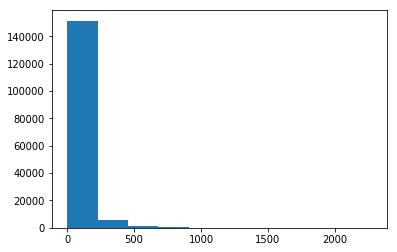

In [6]:
plt.hist(train['comment_text'].apply(lambda x: len(x.split(' '))))

In [7]:
# from nltk.corpus import stopwords
# cachedStop =  stopwords.words('english')
# pattern = re.compile(r'\b(' + r'|'.join(stopwords.words('english')) + r')\b\s*')
# def cleanwords(sent):
#     return ' '.join([word.lower() for word in sent.lower().split() if word not in cachedStop ])
    # return pattern.sub('', sent.lower())

# def cleanchars(sent):
#     return sent.translate(translator)


Standard keras preprocessing, to turn each comment into a list of word indexes of equal length (with truncation or padding as needed).

In [7]:
tokenizer = Tokenizer(char_level=True)
tokenizer.fit_on_texts(list(list_sentences_train))
list_tokenized_train = tokenizer.texts_to_sequences(list_sentences_train)
list_tokenized_test = tokenizer.texts_to_sequences(list_sentences_test)
X_t = pad_sequences(list_tokenized_train, maxlen=maxlen)
X_te = pad_sequences(list_tokenized_test, maxlen=maxlen)

In [8]:
max_features = len(tokenizer.word_counts)+1

In [9]:
max_features

2336

Read the glove word vectors (space delimited strings) into a dictionary from word->vector.

In [10]:
word_index = tokenizer.word_index
nb_words = min(max_features, len(word_index))+1
# embedding_matrix = np.random.normal(0, 1, (nb_words, embed_size))
# for word, i in word_index.items():
#     if i >= max_features: continue # greater than max word features
#     embedding_vector = embeddings_index.get(word) # out of word vocabulary
#     if embedding_vector is not None: embedding_matrix[i] = embedding_vector

Simple bidirectional LSTM with two fully connected layers. We add some dropout to the LSTM since even 2 epochs is enough to overfit.

In [26]:
nf = [(64,2),(128,2),(256,2),(512,2)]
nf[-1][0]

512

In [40]:
def build_model(num_filters, num_classes, sequence_max_length=maxlen, num_quantized_chars=71, embedding_size=16, learning_rate=0.001, top_k=8, model_path=None):

    inputs = Input(shape=(sequence_max_length, ), dtype='int32', name='inputs')

    embedded_sent = Embedding(num_quantized_chars, embedding_size, input_length=sequence_max_length)(inputs)

    # First conv layer
    conv = Conv1D(filters=64, kernel_size=3, strides=2, padding="same")(embedded_sent)

    # Each ConvBlock with one MaxPooling Layer
#     for i in range(len(num_filters)):
#         conv = ConvBlockLayer(get_conv_shape(conv), num_filters[i])(conv)
#         conv = MaxPooling1D(pool_size=3, strides=2, padding="same")(conv)

    for i in range(len(num_filters)):
        for j in range(num_filters[i][1]):
            conv = Conv1D(filters=num_filters[i][0], kernel_size=3, strides=1, padding="same")(conv)
            conv = BatchNormalization()(conv)
            conv = Activation('relu')(conv)
#         print(num_filters[0],num_filters[1])
        conv = MaxPooling1D(pool_size=3, strides=2, padding="same")(conv)
    
#     conv = GlobalAveragePooling1D()(conv)
#     conv = GlobalMaxPool1D()(conv)
    # k-max pooling (Finds values and indices of the k largest entries for the last dimension)
    def _top_k(x):
        x = tf.transpose(x, [0, 2, 1])
        k_max = tf.nn.top_k(x, k=top_k)
        return tf.reshape(k_max[0], (-1, num_filters[-1][0] * top_k))
    k_max = Lambda(_top_k, output_shape=(num_filters[-1][0] * top_k,))(conv)

    # 3 fully-connected layer with dropout regularization
#     fc1 = Dropout(0.2)(Dense(4096, activation='relu', kernel_initializer='he_normal')(k_max))
#     fc2 = Dropout(0.2)(Dense(2048, activation='relu', kernel_initializer='he_normal')(fc1))
#     fc3 = Dense(num_classes, activation='sigmoid')(fc2)

# 3 fully-connected layer 
    fc1 = Dense(4096, activation='relu', kernel_initializer='he_normal')(k_max)
    fc2 = Dense(2048, activation='relu', kernel_initializer='he_normal')(fc1)
    fc3 = Dense(num_classes, activation='sigmoid')(fc2)


    # define optimizer - 10-15 epochs
    sgd = optimizers.SGD(lr=0.01, decay=1e-6, momentum=0.9, nesterov=False)
    model = Model(inputs=inputs, outputs=fc3)
    model.compile(optimizer=sgd, loss='binary_crossentropy', metrics=['accuracy'])

    if model_path is not None:
        model.load_weights(model_path)

    return model

In [41]:
num_filters = [(64,4),(128,4),(256,4),(512,4)]
# Try 10,10,4,4
model = build_model(num_filters=num_filters, num_classes=6, embedding_size=embed_size, learning_rate=0.01)

In [42]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
inputs (InputLayer)          (None, 1024)              0         
_________________________________________________________________
embedding_11 (Embedding)     (None, 1024, 16)          1136      
_________________________________________________________________
conv1d_124 (Conv1D)          (None, 512, 64)           3136      
_________________________________________________________________
conv1d_125 (Conv1D)          (None, 512, 64)           12352     
_________________________________________________________________
batch_normalization_113 (Bat (None, 512, 64)           256       
_________________________________________________________________
activation_113 (Activation)  (None, 512, 64)           0         
_________________________________________________________________
conv1d_126 (Conv1D)          (None, 512, 64)           12352     
__________

Now we're ready to fit out model! Use `validation_split` when not submitting.

In [44]:
model.fit(X_t, y, batch_size=128, epochs=1, validation_split=0.1)

Train on 143613 samples, validate on 15958 samples
Epoch 1/1
143613/143613 [==============================] - 177s 1ms/step - loss: 0.1239 - acc: 0.9638 - val_loss: 0.1193 - val_acc: 0.9638


In [55]:
import math
lrate = 0.01 * math.exp(-0.1*3)
lrate

0.007408182206817179

In [ ]:
K.set_value(model.optimizer.lr, 0.007)
model.fit(X_t, y, batch_size=128, epochs=1, validation_split=0.1)

Train on 143613 samples, validate on 15958 samples
Epoch 1/1
 14336/143613 [=>............................] - ETA: 2:24 - loss: 0.1113 - acc: 0.9654

In [66]:
model.fit(X_t, y, batch_size=128, epochs=2, validation_split=0.1);

Train on 143613 samples, validate on 15958 samples
Epoch 1/2
143613/143613 [==============================] - 98s 683us/step - loss: 0.0721 - acc: 0.9769 - val_loss: 0.0716 - val_acc: 0.9768
Epoch 2/2
143613/143613 [==============================] - 98s 686us/step - loss: 0.0669 - acc: 0.9781 - val_loss: 0.0725 - val_acc: 0.9771


And finally, get predictions for the test set and prepare a submission CSV:

In [69]:
y_test = model.predict([X_te], batch_size=1024, verbose=1)
sample_submission = pd.read_csv('data/sample_submission.csv')
sample_submission[list_classes] = y_test
sample_submission.to_csv('vdcnn.csv', index=False)

153164/153164 [==============================] - 22s 144us/step


In [4]:
# sample_submission.to_csv('base_test.csv',index=False)

In [19]:
# test_submission = pd.read_csv('data/sample_submission.csv')
# len(test_submission)

In [ ]:
# Baseline Score
# loss: 0.0417 - acc: 0.9840 - val_loss: 0.0451 - val_acc: 0.9829 --> AUC : 0.9787

